<a href="https://colab.research.google.com/github/jx-dohwan/Aiffel_NLP_Project/blob/main/%5BNLP_12%5DCreate_a_cool_chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [NLP_12]Create a cool chatbot

## 1. Import 및 라이브러리 다운로드

In [1]:
! pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 12.2 MB/s 


In [2]:
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash


--2022-10-18 01:13:07--  https://www.dropbox.com/s/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.66.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.66.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz [following]
--2022-10-18 01:13:07--  https://www.dropbox.com/s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc427d5b71ca72a9ac40e663357c.dl.dropboxusercontent.com/cd/0/get/BvD1Fxw5W6w8wXM8MLD9ciyvgZK5qA5cAOBhnv-6NI53GVBeUZUPD3wmugolhY2XPQsLS254BYVBBPISmJmy-ULuy7ZbuRPntSC3ojd6B74xsOdUcj5Ia5ZCH7306BTsJ7mZ8eV5DAa8qSwpGW_pNTHQLJUttPEhA5777VYeqpZuy41b2RZMiR0QYXL2N8jnqn0/file?dl=1# [following]
--2022-10-18 01:13:08--  https://uc427d5b71ca72a9ac40e663357c.dl.dropboxusercontent.com/cd/0/get/BvD1Fxw5W

In [84]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sentencepiece as spm
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
from konlpy.tag import Mecab

import re
import os
import random
import math
import urllib.request
import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

mecab = Mecab()

## 2. 데이터 다운로드
준비하기 단계에서 심볼릭 링크를 생성했다면 아래 파일이 ChatbotData .csv라는 이름으로 저장되어 있을거예요. csv 파일을 읽는 데에는 pandas 라이브러리가 적합합니다. 읽어 온 데이터의 질문과 답변을 각각 questions, answers 변수에 나눠서 저장하세요!
- https://github.com/songys/Chatbot_data

- 일반 https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv 링크로는 오류가 생김 
- 이유는 웹 페이지 자체를 링크하기 때문임 그래서 raw를 선택하여 데이터만 있는 링크를 가지고 학습을 진행해야 함

In [54]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv", filename="ChatBotData.csv")
train_data = pd.read_csv('ChatBotData.csv')
train_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


- https://stackoverflow.com/questions/18039057/python-pandas-error-tokenizing-data

In [55]:
questions = []
answers = []
for i in range(len(train_data)):
  # 전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용.
  questions.append(str(train_data['Q'].values[i]))
  answers.append(str(train_data['A'].values[i]))

In [56]:
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [57]:
print(questions[100])
print(answers[100])

거지됐어
밥 사줄 친구를 찾아 보세요~


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 15
텍스트의 평균 길이 : 3.587414361837097
요약의 최소 길이 : 1
요약의 최대 길이 : 21
요약의 평균 길이 : 3.6936479742874058


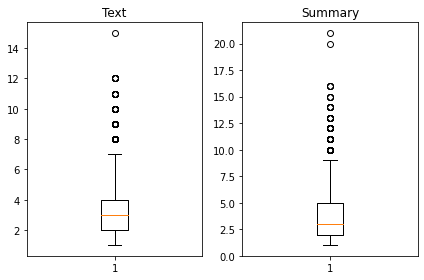

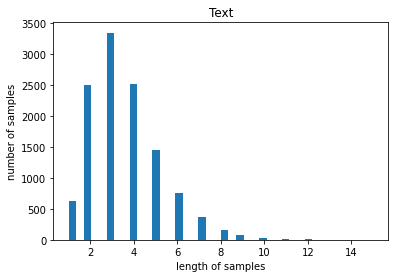

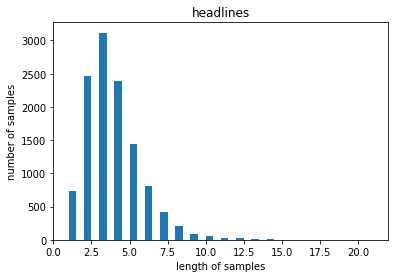

In [58]:
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in questions]
headlines_len = [len(s.split()) for s in answers]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

## 3. 데이터 정제
아래 조건을 만족하는 preprocess_sentence() 함수를 구현하세요.

1. 영문자의 경우, 모두 소문자로 변환합니다.
2. 영문자와 한글, 숫자, 그리고 주요 특수문자를 제외하곤 정규식을 활용하여 모두 제거합니다.

문장부호 양옆에 공백을 추가하는 등 이전과 다르게 생략된 기능들은 우리가 사용할 토크나이저가 지원하기 때문에 굳이 구현하지 않아도 괜찮습니다!

In [59]:
def preprocess_sentence(sentence):
  sentence = sentence.lower()
  sentence = re.sub(r"[^가-힣0-9a-zA-Z?.!,]+", " ", sentence)

## 4. 데이터 토큰화
토큰화에는 KoNLPy의 mecab 클래스를 사용합니다.

아래 조건을 만족하는 build_corpus() 함수를 구현하세요!

1. 소스 문장 데이터와 타겟 문장 데이터를 입력으로 받습니다.
2. 데이터를 앞서 정의한 preprocess_sentence() 함수로 정제하고, 토큰화합니다.
3. 토큰화는 전달받은 토크나이즈 함수를 사용합니다. 이번엔 mecab.morphs 함수를 전달하시면 됩니다.
4. 토큰의 개수가 일정 길이 이상인 문장은 데이터에서 제외합니다.
5. 중복되는 문장은 데이터에서 제외합니다. 소스 : 타겟 쌍을 비교하지 않고 소스는 소스대로 타겟은 타겟대로 검사합니다. 중복 쌍이 흐트러지지 않도록 유의하세요!

구현한 함수를 활용하여 questions 와 answers 를 각각 que_corpus , ans_corpus 에 토큰화하여 저장합니다.

In [69]:
def build_corpus(sentence):
  corpus = []
  for raw in sentence:
    preprocess_sentence(raw)
    raw = mecab.morphs(raw)
    if len(raw) <= 15:
      corpus.append(list(set(raw)))
    

  return corpus

In [70]:
que_corpus = build_corpus(questions)
ans_corpus = build_corpus(answers)

In [71]:
print(que_corpus[100])
print(ans_corpus[100])

print(len(que_corpus))
print(len(ans_corpus))

['거지', '어', '됐']
['해', '세요', '을', '보', '.', '운동']
11488
11337


## 5. Augmentation
우리에게 주어진 데이터는 1만 개가량으로 적은 편에 속합니다. 이럴 때에 사용할 수 있는 테크닉을 배웠으니 활용해 봐야겠죠? Lexical Substitution을 실제로 적용해 보도록 하겠습니다.

아래 링크를 참고하여 한국어로 사전 훈련된 Embedding 모델을 다운로드합니다. Korean (w) 가 Word2Vec으로 학습한 모델이며 용량도 적당하므로 사이트에서 Korean (w)를 찾아 다운로드하고, ko.bin 파일을 얻으세요!

- https://github.com/Kyubyong/wordvectors

다운로드한 모델을 활용해 데이터를 Augmentation 하세요! 앞서 정의한 lexical_sub() 함수를 참고하면 도움이 많이 될 겁니다.

Augmentation된 que_corpus 와 원본 ans_corpus 가 병렬을 이루도록, 이후엔 반대로 원본 que_corpus 와 Augmentation된 ans_corpus 가 병렬을 이루도록 하여 전체 데이터가 원래의 3배가량으로 늘어나도록 합니다.

- 참고 자료
  - https://github.com/jx-dohwan/Aiffel_EGLMS_Project/blob/main/%5BExp_8%5DAnalyzing_the_Sensibility_of_Film_Review_Texts.ipynb
  - https://omicro03.medium.com/%EC%9E%90%EC%97%B0%EC%96%B4%EC%B2%98%EB%A6%AC-nlp-14%EC%9D%BC%EC%B0%A8-word2vec-%EC%8B%A4%EC%8A%B52-8e518a358b6c

In [86]:
word2vec_file_path_lstm = '/content/drive/MyDrive/인공지능/아이펠/GoingDeeper/제출용/data/ko.bin'
ko_model = gensim.models.Word2Vec.load(word2vec_file_path_lstm)
ko_model.most_similar('사과')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


[('사죄', 0.5442899465560913),
 ('충고', 0.4946415424346924),
 ('질문', 0.48838865756988525),
 ('해명', 0.48268449306488037),
 ('대답', 0.4778830409049988),
 ('선처', 0.4665257930755615),
 ('질타', 0.4546084403991699),
 ('발언', 0.4542806148529053),
 ('회답', 0.45340797305107117),
 ('고소', 0.45193421840667725)]

In [96]:
def lexical_sub(sentence, word2vec):
    res = ""
    toks = sentence

    try:
        _from = random.choice(toks)
        _to = word2vec.most_similar(_from)[0][0]
        
    except:   # 단어장에 없는 단어
        return None

    for tok in toks:
        if tok is _from: res += _to + " "
        else: res += tok + " "

    return res

In [97]:
def Augmentation_model(que_corpus , ans_corpus, ko_model):
    new_que_corpus = []
    new_ans_corpus = []

    for i in tqdm(range(len(que_corpus))):
        new_que = lexical_sub(que_corpus[i], ko_model)
        new_ans = lexical_sub(ans_corpus[i], ko_model)

        if new_que is not None: 
            new_que_corpus.append(new_que)
            new_ans_corpus.append(ans_corpus[i])
        
        if new_ans is not None:
            new_ans_corpus.append(new_ans)
            new_que_corpus.append(que_corpus[i])
          
    print(new_que_corpus[:10])
    print(new_ans_corpus[:10])

    return new_que_corpus, new_ans_corpus

In [98]:
new_que_corpus, new_ans_corpus = Augmentation_model(que_corpus , ans_corpus, ko_model)

  0%|          | 0/11488 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  import sys


IndexError: ignored

## 6. 데이터 벡터화
타겟 데이터인 ans_corpus 에 <start> 토큰과 <end> 토큰이 추가되지 않은 상태이니 이를 먼저 해결한 후 벡터화를 진행합니다. 우리가 구축한 ans_corpus 는 list 형태이기 때문에 아주 쉽게 이를 해결할 수 있답니다!

1. 위 소스를 참고하여 타겟 데이터 전체에 <start> 토큰과 <end> 토큰을 추가해 주세요!

챗봇 훈련 데이터의 가장 큰 특징 중 하나라고 하자면 바로 소스 데이터와 타겟 데이터가 같은 언어를 사용한다는 것이겠죠. 앞서 배운 것처럼 이는 Embedding 층을 공유했을 때 많은 이점을 얻을 수 있습니다.

2. 특수 토큰을 더함으로써 ans_corpus 또한 완성이 되었으니, que_corpus 와 결합하여 전체 데이터에 대한 단어 사전을 구축하고 벡터화하여 enc_train 과 dec_train 을 얻으세요!

## 7. 훈련하기
앞서 번역 모델을 훈련하며 정의한 Transformer 를 그대로 사용하시면 됩니다! 대신 데이터의 크기가 작으니 하이퍼파라미터를 튜닝해야 과적합을 피할 수 있습니다. 모델을 훈련하고 아래 예문에 대한 답변을 생성하세요! 가장 멋진 답변과 모델의 하이퍼파라미터를 제출하시면 됩니다.

## 8. 성능 측정하기
챗봇의 경우, 올바른 대답을 하는지가 중요한 평가 지표입니다. 올바른 답변을 하는지 눈으로 확인할 수 있겠지만, 많은 데이터의 경우는 모든 결과를 확인할 수 없을 것입니다. 주어진 질문에 적절한 답변을 하는지 확인하고, BLEU Score를 계산하는 calculate_bleu() 함수도 적용해 보세요.